# Linear computations for choice-induced bias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, FancyArrowPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from scipy.stats import wilcoxon
from statsmodels.stats.weightstats import DescrStatsW

from dynamic_bias import utils
from dynamic_bias.analyses.behavior import PsychometricFunction
from dynamic_bias.analyses.behavior import NearReferenceStatistics
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/outputs/rnn")

# rnn activities
ra = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/demo_rnn_activity.pickle')

# state-space responses
pca_shared = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_pca.pickle')
ss = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_state_space.pickle')
ss_s = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_state_space_strengths.pickle')

# connectivity params
params = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/params_connectivity.pickle')

# rnn behaviors
data_het  = utils.load(f"{utils.ORIGIN}/data/outputs/rnn/results_heterogeneous.pickle")
data_het_d2e_ablation = utils.load(f"{utils.ORIGIN}/data/outputs/rnn/results_heterogeneous_d2e_ablation.pickle")
nrvs = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_near_reference_variability.pickle')

downloading data/outputs/rnn...
data/outputs/rnn already exists. Skipping download...


---
## Comparing PCA components and sinusoids

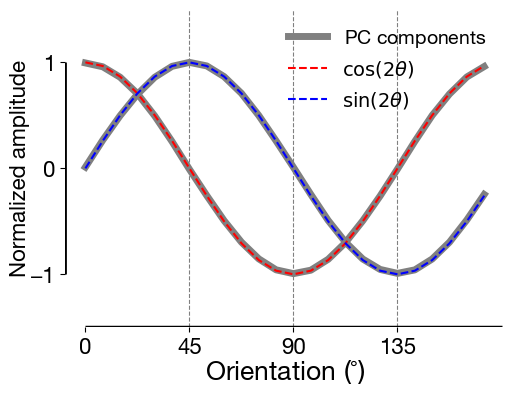

In [3]:
f = plt.figure()
ax = plt.gca()
utils.set_size([4,3])

phi, flip  = utils.fit_rotation( pca_shared.components_.T )
components = utils.rotate(pca_shared.components_.T, -phi, flip=flip, late_flip=False).T
components = components / np.max( np.abs(components) )
harmon     = utils.harmonics()

plt.plot(utils.exp_stim_list(), components[0], color='gray', lw=5)
plt.plot(utils.exp_stim_list(), components[1], color='gray', lw=5, label=r' $\!$PC components')
plt.plot(utils.exp_stim_list(), harmon[0], color='red',  linestyle='dashed', label=r'$\cos(2\theta)$')
plt.plot(utils.exp_stim_list(), harmon[1], color='blue', linestyle='dashed', label=r'$\sin(2\theta)$')

plt.axvline(x=45, color='gray', linestyle='dashed', lw=0.8, zorder=-3)
plt.axvline(x=90, color='gray', linestyle='dashed', lw=0.8, zorder=-3)
plt.axvline(x=135, color='gray', linestyle='dashed', lw=0.8, zorder=-3)

plt.ylim([-1.5,1.5])
plt.legend(frameon=False, loc='upper right')
utils.draw_publish_axis(ax, xrange=(0,180), yrange=(-1,1), xticks=[0,45,90,135], yticks=[-1,0,1])

if utils.LABEL:
    ax.set_xlabel(r"Orientation $(\!\!^\circ\!\!)$", labelpad=0)
    ax.set_ylabel(r"Normalized amplitude", labelpad=0, fontsize=16)

plt.savefig(f'{utils.DIR_FIGURE}/figs8a.pdf',bbox_inches='tight', transparent=True)
plt.show()

---
## Rank-3 approximation of trained $\mathbf{J}$

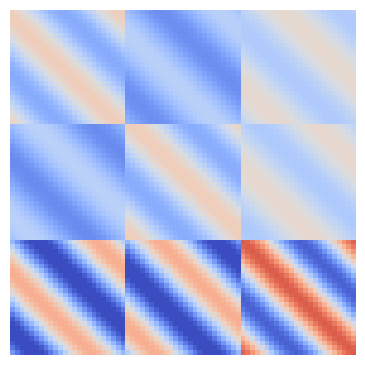

In [4]:
concat = np.concatenate
J_recon_hom = concat([
    concat([params['J_recon_hom'][blk] for blk in ['J00', 'J01', 'J02']],axis=1),
    concat([params['J_recon_hom'][blk] for blk in ['J10', 'J11', 'J12']],axis=1),
    concat([params['J_recon_hom'][blk] for blk in ['J20', 'J21', 'J22']],axis=1),
],axis=0)

plt.figure()
ax = plt.gca()
utils.set_size([3,3])
plt.imshow(J_recon_hom, clim=[-0.35,0.35], cmap='coolwarm')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{utils.DIR_FIGURE}/figs8b_l.pdf',bbox_inches='tight', transparent=True)
plt.show()

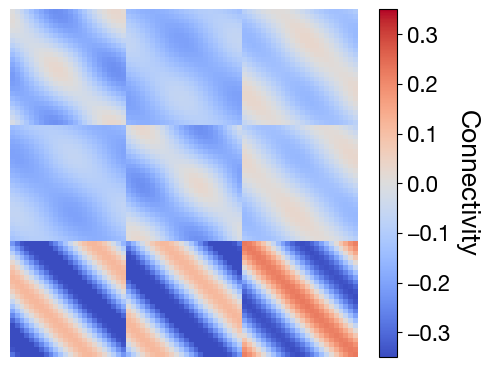

In [5]:
J_recon_het = concat([
    concat([params['J_recon_het'][blk] for blk in ['J00', 'J01', 'J02']],axis=1),
    concat([params['J_recon_het'][blk] for blk in ['J10', 'J11', 'J12']],axis=1),
    concat([params['J_recon_het'][blk] for blk in ['J20', 'J21', 'J22']],axis=1),
],axis=0)

plt.figure()
ax = plt.gca()
utils.set_size([4,3])
plt.imshow(J_recon_het, clim=[-0.35,0.35], cmap='coolwarm')
plt.axis('off')

cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('Connectivity', rotation=270)

plt.tight_layout()
plt.savefig(f'{utils.DIR_FIGURE}/figs8b_r.pdf',bbox_inches='tight', transparent=True)
plt.show()

---
## Linear construction of choice-induced bias

In [6]:
theta = np.linspace(0, 2 * np.pi, 250)
ucirc = np.array([np.cos(theta), np.sin(theta)])
rvec  = -np.pi/6. # absolute reference orientation (in direction space)

def tgnt(x, slope, point):
    orth_slope = -1 / slope
    orth_inter = point[1] - orth_slope*point[0]
    return orth_slope*np.array(x)+orth_inter

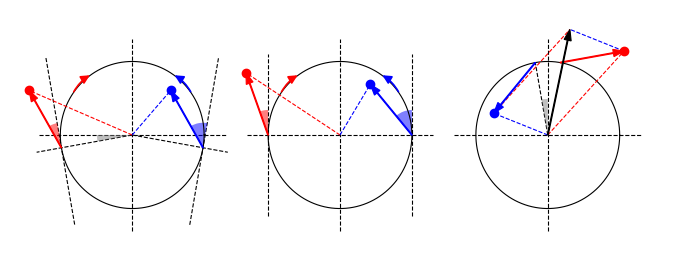

In [7]:
f,ax = plt.subplots(1,3, gridspec_kw={'wspace': -0.15})
utils.set_size([6.6,2.5])

w_xy  = [1.3,1]
w_phi = 0.1
l_phi = 0.1
phi0  = np.pi/18.
phi1  = np.pi/18.

# [0] relevant quantities
rvec0 = np.array( [np.sin(rvec),  np.cos(rvec)] )
w_p0  = np.array( [w_xy[0]*np.cos(w_phi), w_xy[1]*np.sin(w_phi)] )
l_p0  = np.array( [w_xy[0]*np.cos(l_phi), w_xy[1]*np.sin(l_phi)] )

# [1] draw the lines
dstyle = dict(linestyle='dashed', lw=0.8, color='k', zorder=-3)
## [1-1] draw the circles
for i in range(3):
    ax[i].plot(ucirc[0], ucirc[1], color='k', lw=0.8)
    ax[i].set_xlim([-1.7,1.7])
    ax[i].set_ylim([-1.7,1.7])
    ax[i].axis('off')

## [1-2] draw vertical & horizontal lines
for i in range(3):
    ax[i].vlines(0, -1.3,1.3, **dstyle)
    ax[i].hlines(0, -1.3,1.3, **dstyle)


# [2] stability points
## [2-1] define stability points
pphi_W = np.array([np.cos(np.pi+phi0), np.sin(np.pi+phi0)]) # winner at stability (prior to DM)
pphi_L = np.array([np.cos(-phi0), np.sin(-phi0)]) # loser at stability (prior to DM)

## [2-2] phi0 lines from origin
ax[0].plot([0,1.35*pphi_W[0]], [0,1.35*pphi_W[1]], **dstyle)
ax[0].plot([0,1.35*pphi_L[0]], [0,1.35*pphi_L[1]], **dstyle)

## [2-3] tangent lines
rx_W = [-1.2,-0.8]
ry_W = tgnt(rx_W, pphi_W[1]/pphi_W[0], pphi_W)
rx_L = [0.8,1.2,]
ry_L = tgnt(rx_L, pphi_L[1]/pphi_L[0], pphi_L)
ax[0].plot(rx_W, ry_W, **dstyle)
ax[0].plot(rx_L, ry_L, **dstyle)

## [2-4] put Wedge to represent phi0
wedge = Wedge(center=(0,0), r=0.01, alpha=0.5,
              theta1=np.rad2deg(utils.wrap(0)), 
              theta2=np.rad2deg(utils.wrap(phi0)), 
              width=.5, lw=0, color='gray', transform=ax[0].transData)
ax[0].add_patch(wedge)

## [2-5] tangent lines into vertical lines
ax[1].vlines(-1, -1.1, 1.1, **dstyle)
ax[1].vlines( 1, -1.1, 1.1, **dstyle)


# [3] reference inputs
## [3-1] stability points + inputs
I_W = 0.9 * np.array([np.cos(np.pi/2.-rvec),np.sin(np.pi/2.-rvec)]) # input direction (winner)
I_L = 0.9 * np.array([np.cos(np.pi/2.-rvec),np.sin(np.pi/2.-rvec)]) # input direction (loser)

ax[0].scatter( *(pphi_W+I_W), color='red', zorder=4)
ax[0].plot(*zip([0,0],pphi_W+I_W), color='red', linestyle='dashed', lw=0.8)
ax[0].arrow(*pphi_W, *I_W, color='red', lw=0.8,
            length_includes_head=True, width=0.012, head_width=0.1, zorder=3,)

ax[0].scatter( *(pphi_L+I_L), color='blue', zorder=4)
ax[0].plot(*zip([0,0],pphi_L+I_L), color='blue', linestyle='dashed', lw=0.8)
ax[0].arrow(*pphi_L, *I_L, color='blue', lw=0.8,
            length_includes_head=True, width=0.012, head_width=0.1, zorder=3,)

## [3-2] put Wedge to represent theta_tilde-phi0
wedge = Wedge(center=pphi_W, r=0.01, alpha=0.5,
              theta1=np.rad2deg(-np.pi/2+phi0), 
              theta2=np.rad2deg(-np.pi/2+phi0+(-rvec-phi0)), 
              width=.35, lw=0, color='red', transform=ax[0].transData)
ax[0].add_patch(wedge)

## [3-3] put Wedge to represent theta_tilde+phi0
wedge = Wedge(center=pphi_L, r=0.01, alpha=0.5,
              theta1=np.rad2deg(-np.pi/2-phi0), 
              theta2=np.rad2deg(-np.pi/2-phi0+(-rvec+phi0)), 
              width=.35, lw=0, color='blue', transform=ax[0].transData)
ax[0].add_patch(wedge)

## [3-4] rotate everything to match vertical shift
ax[1].scatter( *utils.rotate(pphi_W+I_W, -phi0), color='red', zorder=4)
ax[1].plot(*zip([0,0],utils.rotate(pphi_W+I_W, -phi0)), color='red', linestyle='dashed', lw=0.8)
ax[1].arrow(*[-1,0], *utils.rotate(I_W, -phi0), color='red', lw=0.8,
            length_includes_head=True, width=0.012, head_width=0.1, zorder=3,)

ax[1].scatter( *utils.rotate(pphi_L+I_L, phi0), color='blue', zorder=4)
ax[1].plot(*zip([0,0],utils.rotate(pphi_L+I_L, phi0)), color='blue', linestyle='dashed', lw=0.8)
ax[1].arrow(*[1,0], *utils.rotate(I_L, phi0), color='blue', lw=0.8,
            length_includes_head=True, width=0.012, head_width=0.1, zorder=3,)

## [3-5] put rotated Wedge to represent theta_tilde-phi0
wedge = Wedge(center=[-1,0], r=0.01, alpha=0.5,
              theta1=np.rad2deg(-np.pi/2), 
              theta2=np.rad2deg(-np.pi/2+(-rvec-phi0)), 
              width=.35, lw=0, color='red', transform=ax[1].transData)
ax[1].add_patch(wedge)

## [3-6] put rotated Wedge to represent theta_tilde+phi0
wedge = Wedge(center=[1,0], r=0.01, alpha=0.5,
              theta1=np.rad2deg(-np.pi/2), 
              theta2=np.rad2deg(-np.pi/2+(-rvec+phi0)), 
              width=.35, lw=0, color='blue', transform=ax[1].transData)
ax[1].add_patch(wedge)


## [4-1] rotation into stimulus population
rot_w = -phi0 - np.pi/2 - phi1
ax[2].scatter( *utils.rotate(pphi_W+I_W, rot_w), color='red', zorder=4)
ax[2].plot(*zip([0,0],utils.rotate(pphi_W+I_W, rot_w)), color='red', linestyle='dashed', lw=0.8)
ax[2].arrow(*utils.rotate(pphi_W, rot_w), *utils.rotate(I_W, rot_w), color='red', lw=0.8,
            length_includes_head=True, width=0.012, head_width=0.1, zorder=3,)

rot_l = phi0 + np.pi/2 + phi1
ax[2].scatter( *utils.rotate(pphi_L+I_L, rot_l), color='blue', zorder=4)
ax[2].plot(*zip([0,0],utils.rotate(pphi_L+I_L, rot_l)), color='blue', linestyle='dashed', lw=0.8)
ax[2].arrow(*utils.rotate(pphi_L, rot_l), *utils.rotate(I_L, rot_l), color='blue', lw=0.8,
            length_includes_head=True, width=0.012, head_width=0.1, zorder=3,)

## [4-2] put Wedge to represent phi1
ax[2].plot(*zip([0,0],utils.rotate([0,1], phi1)),  **dstyle)

wedge = Wedge(center=(0,0), r=0.01, alpha=0.5,
              theta1=np.rad2deg(utils.wrap(-np.pi/2)), 
              theta2=np.rad2deg(utils.wrap(-np.pi/2+phi1)), 
              width=.5, lw=0, color='gray', transform=ax[2].transData)
ax[2].add_patch(wedge)

## [4-3] parallelogram
ax[2].plot(*zip(utils.rotate(pphi_W+I_W, rot_w), 
                utils.rotate(pphi_W+I_W, rot_w)+utils.rotate(pphi_L+I_L, rot_l)), color='blue', linestyle='dashed', lw=0.8)
ax[2].plot(*zip(utils.rotate(pphi_L+I_L, rot_l), 
                utils.rotate(pphi_L+I_L, rot_l)+utils.rotate(pphi_W+I_W, rot_w)), color='red', linestyle='dashed', lw=0.8)

ax[2].arrow(*[0,0], *(utils.rotate(pphi_W+I_W, rot_w)+utils.rotate(pphi_L+I_L, rot_l)), color='k', lw=0.8,
            length_includes_head=True, width=0.012, head_width=0.1, zorder=3,)

# [5] add moving arrows
for ifig in range(2):
    for angs, ange, curv, col in zip(
        [np.pi*(2.5/8), -np.pi*(2.5/8)], [-np.pi/8, np.pi/8], [-0.16,0.16], ['red', 'blue']):
        a1  = np.pi/2 + angs
        a2  = a1 + ange
        c1  = np.array([np.cos(a1), np.sin(a1)])
        c2  = np.array([np.cos(a2), np.sin(a2)])
        arr = FancyArrowPatch(c1, c2, connectionstyle=f"arc3,rad={curv}", arrowstyle='-|>',
                              mutation_scale=13, lw=1.2, color=col, zorder=4)
        ax[ifig].add_patch(arr)

plt.savefig(f'{utils.DIR_FIGURE}/figs8cde.pdf',bbox_inches='tight', transparent=True)
plt.show()

---
## Linear construction of choice-induced bias under drift

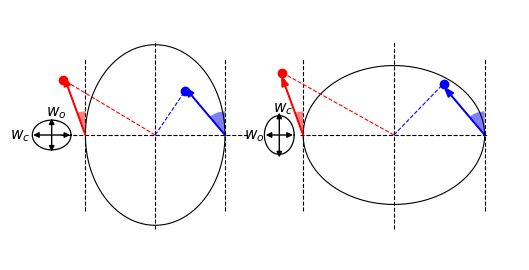

In [8]:
# curved arrows?
f,ax = plt.subplots(1,2, gridspec_kw={'wspace': -0.05})
utils.set_size([4.9,2.5])

w_xy = [1.3,1]
w_phi, l_phi = 0.1, 0.1

# [0] relevant quantities
rvec0 = np.array( [np.sin(rvec),  np.cos(rvec)] )
w_p0  = np.array( [w_xy[0]*np.cos(w_phi), w_xy[1]*np.sin(w_phi)] )
l_p0  = np.array( [w_xy[0]*np.cos(l_phi), w_xy[1]*np.sin(l_phi)] )

# [1] draw the circle
for i in range(2):
    ax[i].set_xlim([-1.8,1.8])
    ax[i].set_ylim([-1.8,1.8])
    ax[i].axis('off')

ax[0].plot(ucirc[0], w_xy[0] * ucirc[1], color='k', lw=0.8)
ax[1].plot(w_xy[0] * ucirc[0], ucirc[1], color='k', lw=0.8)

## [2-5] tangent lines into vertical lines
for i in range(2):
    ax[i].vlines(0, -1.35, 1.35, **dstyle)
    ax[i].hlines(0, -1.35, 1.35, **dstyle)
ax[0].vlines(-w_xy[1], -1.1, 1.1, **dstyle)
ax[0].vlines( w_xy[1], -1.1, 1.1, **dstyle)
ax[1].vlines(-w_xy[0], -1.1, 1.1, **dstyle)
ax[1].vlines( w_xy[0], -1.1, 1.1, **dstyle)

I_W = 0.9 * np.array([np.cos(np.pi/2.-rvec),np.sin(np.pi/2.-rvec)]) # input direction (winner)
I_L = 0.9 * np.array([np.cos(np.pi/2.-rvec),np.sin(np.pi/2.-rvec)]) # input direction (loser)

# around diverging
pphi_W = np.array([w_xy[1]*np.cos(np.pi+phi0), w_xy[0]*np.sin(np.pi+phi0)]) # winner at stability (prior to DM)
pphi_L = np.array([w_xy[1]*np.cos(-phi0),      w_xy[0]*np.sin(-phi0)]) # loser at stability (prior to DM)

ax[0].scatter( *utils.rotate(pphi_W+I_W, -phi0), color='red', zorder=4)
ax[0].plot(*zip([0,0],utils.rotate(pphi_W+I_W, -phi0)), color='red', linestyle='dashed', lw=0.8)
ax[0].arrow(*[-w_xy[1],0], *utils.rotate(I_W, -phi0), color='red', lw=0.8,
            length_includes_head=True, width=0.012, head_width=0.1, zorder=3,)

ax[0].scatter( *utils.rotate(pphi_L+I_L, phi0), color='blue', zorder=4)
ax[0].plot(*zip([0,0],utils.rotate(pphi_L+I_L, phi0)), color='blue', linestyle='dashed', lw=0.8)
ax[0].arrow(*[w_xy[1],0], *utils.rotate(I_L, phi0), color='blue', lw=0.8,
            length_includes_head=True, width=0.012, head_width=0.1, zorder=3,)

wedge = Wedge(center=[-w_xy[1],0], r=0.01, alpha=0.5,
              theta1=np.rad2deg(-np.pi/2), 
              theta2=np.rad2deg(-np.pi/2+(-rvec-phi0)), 
              width=.35, lw=0, color='red', transform=ax[0].transData)
ax[0].add_patch(wedge)

wedge = Wedge(center=[w_xy[1],0], r=0.01, alpha=0.5,
              theta1=np.rad2deg(-np.pi/2), 
              theta2=np.rad2deg(-np.pi/2+(-rvec+phi0)), 
              width=.35, lw=0, color='blue', transform=ax[0].transData)
ax[0].add_patch(wedge)


# diverging side
ax_inset = f.add_axes([0.05, 0.385, 0.22, 0.22])  # [left, bottom, width, height]
ax_inset.plot(w_xy[0]*ucirc[0], w_xy[1]*ucirc[1], color='k', linewidth=0.9)
ax_inset.annotate(text='', xy=[-w_xy[0]*1.1, 0], xytext=[w_xy[0]*1.1, 0], arrowprops=dict(color='k', mutation_scale=8, arrowstyle='<|-|>'))
ax_inset.annotate(text='', xy=[0, -w_xy[1]*1.3], xytext=[0, w_xy[1]*1.3], arrowprops=dict(color='k', mutation_scale=8, arrowstyle='<|-|>'))
ax_inset.set_xlim([-2.4, 2.4])
ax_inset.set_ylim([-2.4, 2.4])
ax_inset.set_aspect('equal', adjustable='box')
ax_inset.text(-2.8, -0.3, r'$w_c$', fontsize=11)
ax_inset.text(-0.4, 1.25, r'$w_o$', fontsize=11)
ax_inset.axis('off')


# around converging
pphi_W = np.array([w_xy[0]*np.cos(np.pi+phi0), w_xy[1]*np.sin(np.pi+phi0)]) # winner at stability (prior to DM)
pphi_L = np.array([w_xy[0]*np.cos(-phi0),      w_xy[1]*np.sin(-phi0)]) # loser at stability (prior to DM)

ax[1].scatter( *utils.rotate(pphi_W+I_W, -phi0), color='red', zorder=4)
ax[1].plot(*zip([0,0],utils.rotate(pphi_W+I_W, -phi0)), color='red', linestyle='dashed', lw=0.8)
ax[1].arrow(*[-w_xy[0],0], *utils.rotate(I_W, -phi0), color='red', lw=0.8,
            length_includes_head=True, width=0.012, head_width=0.1, zorder=3,)

ax[1].scatter( *utils.rotate(pphi_L+I_L, phi0), color='blue', zorder=4)
ax[1].plot(*zip([0,0],utils.rotate(pphi_L+I_L, phi0)), color='blue', linestyle='dashed', lw=0.8)
ax[1].arrow(*[w_xy[0],0], *utils.rotate(I_L, phi0), color='blue', lw=0.8,
            length_includes_head=True, width=0.012, head_width=0.1, zorder=3,)

wedge = Wedge(center=[-w_xy[0],0], r=0.01, alpha=0.5,
              theta1=np.rad2deg(-np.pi/2), 
              theta2=np.rad2deg(-np.pi/2+(-rvec-phi0)), 
              width=.35, lw=0, color='red', transform=ax[1].transData)
ax[1].add_patch(wedge)

wedge = Wedge(center=[w_xy[0],0], r=0.01, alpha=0.5,
              theta1=np.rad2deg(-np.pi/2), 
              theta2=np.rad2deg(-np.pi/2+(-rvec+phi0)), 
              width=.35, lw=0, color='blue', transform=ax[1].transData)
ax[1].add_patch(wedge)

# converging side
ax_inset = f.add_axes([0.41, 0.385, 0.22, 0.22])  # [left, bottom, width, height]
ax_inset.plot(w_xy[1]*ucirc[0], w_xy[0]*ucirc[1], color='k', linewidth=0.9)
ax_inset.annotate(text='', xy=[-w_xy[1]*1.1, 0], xytext=[w_xy[1]*1.1, 0], arrowprops=dict(color='k', mutation_scale=8, arrowstyle='<|-|>'))
ax_inset.annotate(text='', xy=[0, -w_xy[0]*1.3], xytext=[0, w_xy[0]*1.3], arrowprops=dict(color='k', mutation_scale=8, arrowstyle='<|-|>'))
ax_inset.set_xlim([-2.4, 2.4])
ax_inset.set_ylim([-2.4, 2.4])
ax_inset.set_aspect('equal', adjustable='box')
ax_inset.text(-2.4, -0.3, r'$w_o$', fontsize=11)
ax_inset.text(-0.4, 1.5, r'$w_c$', fontsize=11)
ax_inset.axis('off')

plt.savefig(f'{utils.DIR_FIGURE}/figs8gh.pdf',bbox_inches='tight', transparent=True)
plt.show()


---
## Benefit of choice-induced bias

In [9]:
rps  = 1.
cibs = [utils.ori2dir(o) for o in range(0,12)]
# cibs = [0, 10 * np.pi/90.]
rths = np.linspace(0, np.pi/4., num=12)

simulate_res = utils.nan([len(cibs), len(rths)])
for i_cib, cib in enumerate(cibs):
    for i_rth, rth in enumerate(rths):
        qw = np.array([-np.cos(cib), +np.sin(cib)]) + rps*np.array([-np.sin(rth), np.cos(rth)])
        ql = np.array([+np.cos(cib), -np.sin(cib)]) + rps*np.array([-np.sin(rth), np.cos(rth)])
        simulate_res[i_cib, i_rth] = np.linalg.norm(qw) / np.linalg.norm(ql)

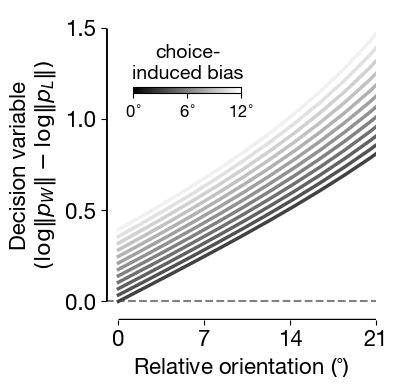

In [18]:
import seaborn as sns
import matplotlib.colors as mc
GRAYS = mc.ListedColormap(sns.color_palette("gray",12))

f = plt.figure()
ax = plt.gca()
utils.set_size([2.7,3.1])

ax.axhline(y=0, linestyle='dashed', color='gray', zorder=-2)
for i in range(12):
    plt.plot( utils.dir2ori(rths), np.log(simulate_res[i]), lw=2.5, color=utils.lighten_color(GRAYS.colors[i], 0.8))
plt.xlim([-1,21])
plt.ylim([-0.1,1.6])

norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(norm=norm, cmap='gray')  # Adjust cmap as needed, e.g., 'viridis' or your specific colormap
sm.set_array([])  # Empty array since we're not plotting actual data

cax = inset_axes(ax, width="100%", height="20%",
                 bbox_to_anchor=(0.1, 0.65, 0.4, 0.1), bbox_transform=ax.transAxes, borderpad=0)
cb = plt.colorbar(sm, cax=cax, orientation="horizontal")
cb.ax.tick_params(labelsize=12)
cb.set_ticks([0,0.5,1])
cb.set_ticklabels([r'0$\!^\circ$', r'6$\!^\circ$', r'12$\!^\circ$'])
ax.text(5.65, 1.22, 'choice-\ninduced bias', size=14, ha='center')

utils.draw_publish_axis(ax, xrange=(0,21), yrange=(0,1.5), xticks=[0,7,14,21], yticks=[0,0.5,1,1.5], tight_layout=False)
ax.set_xlabel(r"Relative orientation $(\!\!^\circ\!\!)$", fontsize=16)
ax.set_ylabel(r"Decision variable" + "\n" + r"$(\mathrm{log} \Vert p_W \Vert - \mathrm{log} \Vert p_L \Vert )$", fontsize=16)
plt.savefig(f'{utils.DIR_FIGURE}/figs8f.pdf',bbox_inches='tight', transparent=True)
plt.show()

---
## Effect of DM $\to$ EM ablation in heterogeneous RNNs

In [11]:
psi = PsychometricFunction()
id_list = np.arange(50)

res_dict = {}
for datan, data in zip(
    ['het', 'het_d2e_ablation'],
    [data_het, data_het_d2e_ablation]
):
    res_dict[datan] = []
    for v_id in id_list:
        idx_id = data['ID']==v_id
        data_fit = {
            'evidence' : -data['relref'][idx_id],
            'choice'   :  data['choice'][idx_id],
        }

        # fit the psychometric function
        psi.fit(data_fit, ub=[1e2,1e2,1.0])
        res_dict[datan].append(psi.fitted_params)

In [12]:
xx  = np.linspace(-22.5,22.5,num=200)
my1 = np.mean(np.stack([psi(xx, **dict(zip(psi.param_names, res_dict['het'][i_id]))) for i_id in range(50)]),axis=0)
my2 = np.mean(np.stack([psi(xx, **dict(zip(psi.param_names, res_dict['het_d2e_ablation'][i_id]))) for i_id in range(50)]),axis=0)
sy1 = np.std( np.stack([psi(xx, **dict(zip(psi.param_names, res_dict['het'][i_id]))) for i_id in range(50)]),axis=0) / np.sqrt(50)
sy2 = np.std( np.stack([psi(xx, **dict(zip(psi.param_names, res_dict['het_d2e_ablation'][i_id]))) for i_id in range(50)]),axis=0) / np.sqrt(50)

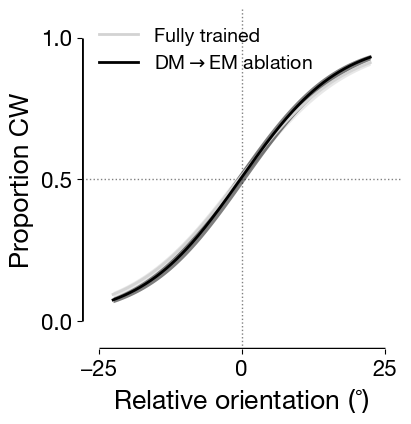

In [13]:
plt.figure()
utils.set_size([3.2,3.4])
ax = plt.gca()

ax.axvline(x=0,   linestyle='dotted', color='gray', linewidth=1., zorder=-4)
ax.axhline(y=0.5, linestyle='dotted', color='gray', linewidth=1., zorder=-4)

ax.plot(xx, my1, color='lightgray', linewidth=2, label='Fully trained')
ax.plot(xx, my2, color='k', linewidth=2, label=r'DM$\rightarrow$EM ablation')
ax.fill_between(xx, my1-sy1, my1+sy1, color='lightgray', alpha=0.5, lw=0, zorder=-3)
ax.fill_between(xx, my2-sy2, my2+sy2, color='k', alpha=0.5, lw=0, zorder=-3)

plt.legend(frameon=False, loc='upper left', fontsize=14)
plt.ylim([-0.1,1.1])
plt.xlim([-28,28])
utils.draw_publish_axis(ax, xrange=(-25,25), yrange=(0,1), xticks=[-25,0,25], yticks=[0,0.5,1], tight_layout=False)

if utils.LABEL:
    ax.set_xlabel(r"Relative orientation $(\!\!^\circ\!\!)$")
    ax.set_ylabel(r"Proportion CW")

plt.savefig(f'{utils.DIR_FIGURE}/figs8i.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [14]:
evi_list = list(nrvs['refwise']['heterogeneous'].keys())

nrv_het_list = np.array([nrvs['refwise']['heterogeneous'][-v] for v in evi_list])
nrv_het_ablate_list = np.array([nrvs['refwise']['heterogeneous_d2e_ablation'][-v] for v in evi_list])

nrv_het_m,  nrv_het_s  = utils.meanstats(nrv_het_list)
nrv_het_em, nrv_het_es = utils.meanstats(nrv_het_ablate_list)

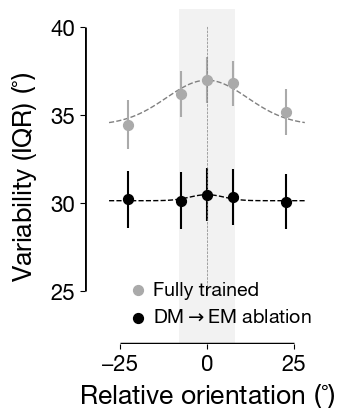

In [15]:
plt.figure()
ax = plt.gca()
utils.set_size([2.8,3.4])

plt.vlines(evi_list, nrv_het_m - nrv_het_s, nrv_het_m + nrv_het_s, color='#AAAAAA', alpha=1)
plt.scatter(evi_list, nrv_het_m, color='#AAAAAA', s=50, zorder=3, label='Fully trained')

plt.vlines(evi_list, nrv_het_em-nrv_het_es, nrv_het_em+nrv_het_es, color='k', alpha=1)
plt.scatter(evi_list, nrv_het_em, color='k', s=50, zorder=3, label=r'DM$\rightarrow$EM ablation')

nrs = NearReferenceStatistics()
nrs.fit_gaussian(evi_list, nrv_het_list.T, init_params=[0,2,1])
xxx = np.linspace(-28,28,100)
yyy = nrs.centered_gaussian(xxx)
plt.plot(xxx, yyy, color='gray', linestyle='dashed', linewidth=1, zorder=-3)

nrs.fit_gaussian(evi_list, nrv_het_ablate_list.T, init_params=[0,2,1])
xxx = np.linspace(-28,28,100)
yyy = nrs.centered_gaussian(xxx)
plt.plot(xxx, yyy, color='k', linestyle='dashed', linewidth=1, zorder=-3)

plt.axvline(x=0, ymin=0.15, ymax=0.95, color='gray', linestyle='dashed', linewidth=0.5)
plt.ylim([22,41])
plt.xlim([-35,35])
plt.legend(frameon=False, handletextpad=-0.2, loc='lower right')
plt.axvspan(-8,8, color='gray', alpha=0.1, zorder=-4, lw=0)

if utils.LABEL:
    ax.set_xlabel(f"Relative orientation $(\!\!^\circ\!\!)$", labelpad=5)
    ax.set_ylabel(f"Variability (IQR) $(\!\!^\circ\!\!)$", labelpad=8)

utils.draw_publish_axis(ax, xrange=(-25,25), yrange=(25,40), xticks=[-25,0,25], yticks=[25,30,35,40])
plt.savefig(f'{utils.DIR_FIGURE}/figs8j.pdf', bbox_inches='tight', transparent=True)
plt.show()

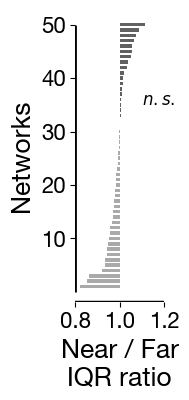

In [16]:
v1 = np.array(nrvs['combined']['heterogeneous_d2e_ablation']['near'])
v2 = np.array(nrvs['combined']['heterogeneous_d2e_ablation']['far'])

plt.figure()
ax = plt.gca()
utils.set_size([1.4,2.8])

patches = plt.barh(np.arange(1,51), np.sort(v1/v2)-1, height=0.66, color='k')
for i,p in enumerate(patches):
    if np.sort(v1/v2)[i] > 1:
        plt.setp(p, "facecolor", '#616161')
    else:
        plt.setp(p, "facecolor", '#AAAAAA')
    
ax.set_xlim([-0.2,0.2])
ax.set_xticks([-0.2,0,0.2])
ax.set_xticklabels([0.8,1.,1.2])
ax.set_yticks([10,20,30,40,50])

ax.text(0.1,35, r'$n.s.$', fontsize=12, color='k')
utils.draw_publish_axis(ax, xrange=(-0.3,0.3), yrange=(0,50), xticks=None, yticks=None)
if utils.LABEL:
    plt.xlabel('Near / Far\nIQR ratio')
    plt.ylabel(r'Networks')
plt.savefig(f'{utils.DIR_FIGURE}/figs8k.pdf',bbox_inches='tight',transparent=True)
plt.show()

In [17]:
for v_model, desc_model in zip(['heterogeneous_d2e_ablation'], ['DM to EM ablated']):
    v1 = np.array(nrvs['combined'][v_model]['near'])
    v2 = np.array(nrvs['combined'][v_model]['far'])
    ttest  = DescrStatsW(v1/v2 - 1)
    wilcox = wilcoxon(v1/v2 - 1)

    print(f"Near-reference variability: Near vs. Far {desc_model}")
    print('\nPaired samples t-test')
    print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
    print('95% CI=', ttest.tconfint_mean())
    print('\nWilcoxon signed-rank test (without continuity correction)')
    print('V=', wilcox[0], 'p=', wilcox[1])

Near-reference variability: Near vs. Far DM to EM ablated

Paired samples t-test
t(49)= -1.5921662191286292 p= 0.11777877516867913
95% CI= (-0.027705615611629673, 0.0032108283954676384)

Wilcoxon signed-rank test (without continuity correction)
V= 474.0 p= 0.11619549807268115
